## Seattle Airbnb Open Data Analysis (Part 3)

This report is split into multiple notebooks as follows.
<br>
###### Part 1 ([link](./Seattle Airbnb Open Data - Part 1.ipynb))
 1 . Business Understanding<br>
 2 . Data Understanding
###### Part 2 ([link](./Seattle Airbnb Open Data - Part 2.ipynb))
 3 . Data Preparation<br>
###### Part 3 (This notebook)
 4 . Data Modeling<br>
 5 . Results Evaluation<br>
###### Blog Post
 6 . Deployment<br>

Before continuing to data preparation, we check business questions we will answer again.
###### Q1: What are the busiest times of the year to visit Seattle? By how much do prices spike?
###### Q2: Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?
###### Q3: How well can we predict a price of Seattle Airbnb listings? What aspects correlate well to price?

We got answers to Q1 and Q2 in part 2. <br>
In part 3, we will make a data model to answer Q3.<br>

### 4. Data Modeling
Let's import necessary libraries again with some modifications.

In [1]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ToDo:
* Load processed listings dataframe from pickle file.
* Set 'price' column as a target of predictig model.
* Split data into training and testing.
* Instantiate model
* Fit training data to model
* Predict price from training/test data

* Load processed listings dataframe from pickle file.

In [2]:
# Loading listings_df
with open('listings_df.pickle', 'rb') as f:
    listings_df = pickle.load(f)

* Set 'price' column as a target of predictig model.

In [3]:
X = listings_df.drop(['price'], axis=1)
y = listings_df['price']

* Split data into training and testing.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

* Instantiate model<br>
We will try three regression models, Linear Regression, Random Forest, and Gradient Boosting.<br>
For the latter two, we will use grid search for optimizing hyper parameters.

In [5]:
# Instantiate models with standard scaler as a pipeline.
pipe_lr = Pipeline([('scl', StandardScaler()), ('est', LinearRegression())])

pipe_rfr = Pipeline(
    [('scl', StandardScaler()), ('est', RandomForestRegressor(random_state=42))])

pipe_gbr = Pipeline([('scl', StandardScaler()),
                     ('est', GradientBoostingRegressor(random_state=42))])

* Fit training data to model

In [6]:
# Straightforward training for Linear Regression
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('est', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [7]:
# For Random Forest Regressor, setting hyperparameter variations for grid seach
param_grid_rfr = {
    'est__n_estimators': [100],              # default: 10
    'est__max_features': [1, 'auto', None],  # default: 'auto'
    'est__max_depth': [1, 5, 10, None],      # default: None
    'est__min_samples_leaf': [1, 2, 4]       # default: 1
}

# Setting grid search parameters
gs_rfr = GridSearchCV(estimator=pipe_rfr,
                      param_grid=param_grid_rfr, scoring='r2', cv=3, verbose=1)

# Fitting training data to model.
gs_rfr = gs_rfr.fit(X_train, y_train)
print('Best Model: %s' % gs_rfr.best_estimator_.named_steps['est'])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  1.9min finished


Best Model: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


In [8]:
# For Gradient Boosting Regressor, setting hyperparameter variations for grid seach
param_grid_gbr = {
    'est__learning_rate': [0.1, 0.05],  # default: 0.1
    'est__max_depth': [3, 4, 5],        # default: 3
    'est__min_samples_leaf': [1, 3, 5]  # default: 1
}

# Setting grid search parameters
gs_gbr = GridSearchCV(estimator=pipe_gbr,
                      param_grid=param_grid_gbr, scoring='r2', cv=3, verbose=1)

# Fitting training data to model.
gs_gbr = gs_gbr.fit(X_train, y_train)
print('Best Model: %s' % gs_gbr.best_estimator_.named_steps['est'])

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   59.2s finished


Best Model: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)


* Predict price from training/test data

In [9]:
# Linear Regression
y_pred_lr_train = pipe_lr.predict(X_train)
y_pred_lr_test = pipe_lr.predict(X_test)

# Random Forest
y_pred_rfr_train = gs_rfr.best_estimator_.predict(X_train)
y_pred_rfr_test = gs_rfr.best_estimator_.predict(X_test)

# Gradient Boosting
y_pred_gbr_train = gs_gbr.best_estimator_.predict(X_train)
y_pred_gbr_test = gs_gbr.best_estimator_.predict(X_test)

In [10]:
# R2 score calculations

# Linear Regression
r2_score_lr_train = r2_score(y_train, y_pred_lr_train)
r2_score_lr_test = r2_score(y_test, y_pred_lr_test)
print('R2 score (Linear Regression, Train Data):{}'.format(r2_score_lr_train))
print('R2 score (Linear Regression, Test Data):{}'.format(r2_score_lr_test))

# Random Forest
y_pred_rfr_train = gs_rfr.best_estimator_.predict(X_train)
y_pred_rfr_test = gs_rfr.best_estimator_.predict(X_test)
r2_score_rfr_train = r2_score(y_train, y_pred_rfr_train)
r2_score_rfr_test = r2_score(y_test, y_pred_rfr_test)
print('R2 score (Random Forest Regressor, Train Data):{}'.format(r2_score_rfr_train))
print('R2 score (Random Forest Regressor, Test Data):{}'.format(r2_score_rfr_test))

# Gradient Boosting
y_pred_gbr_train = gs_gbr.best_estimator_.predict(X_train)
y_pred_gbr_test = gs_gbr.best_estimator_.predict(X_test)
r2_score_gbr_train = r2_score(y_train, y_pred_gbr_train)
r2_score_gbr_test = r2_score(y_test, y_pred_gbr_test)
print('R2 score (Gradient Boosting Regressor, Train Data):{}'.format(r2_score_gbr_train))
print('R2 score (Gradient Boosting Regressor, Test Data):{}'.format(r2_score_gbr_test))

R2 score (Linear Regression, Train Data):0.6216459974175739
R2 score (Linear Regression, Test Data):-689.7073967713843
R2 score (Random Forest Regressor, Train Data):0.9008283660660104
R2 score (Random Forest Regressor, Test Data):0.6547685512906973
R2 score (Gradient Boosting Regressor, Train Data):0.8522767120507979
R2 score (Gradient Boosting Regressor, Test Data):0.6736218370092947


* Linear Regression seems to be failed. Maybe it is suffering from outliers.
* Random Forest R2 score is 0.655. From trainig data predition and test data prediction difference, we could say the model is over fitting a little.
* Gradient Boosting R2 score is 0.674 which is best among three models. This might be also over fitting, but it is less than Random Forest.

### 5. Resutls Evaluation
Let's plot predition results, and also let's check important features for each model.

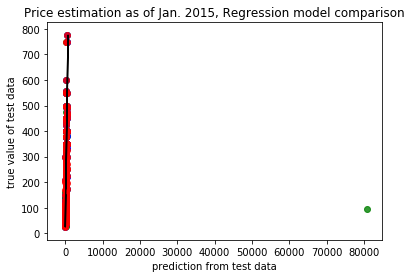

In [11]:
# Test data prediciton plot
plt.scatter(y_pred_lr_test, y_test, c='green', alpha=0.8)
plt.scatter(y_pred_gbr_test, y_test, c='blue', alpha=0.8)
plt.scatter(y_pred_rfr_test, y_test, c='red', alpha=0.8)
plt.xlabel('prediction from test data')
plt.ylabel('true value of test data')
plt.plot(y_test, y_test, c='black')
plt.title('Price estimation as of Jan. 2015, Regression model comparison')
plt.show()

It looks like linear regression suffer from outlier.<br>
We adjust x-axis to see major part.

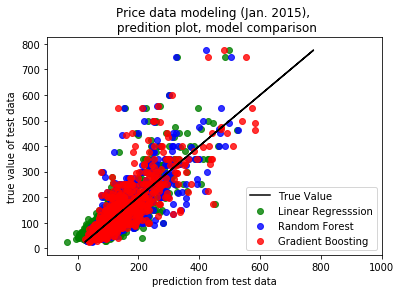

In [12]:
# Plot again with x-axis range adjustment
plt.scatter(y_pred_lr_test, y_test, c='green',
            alpha=0.8, label='Linear Regresssion')
plt.scatter(y_pred_rfr_test, y_test, c='blue',
            alpha=0.8, label='Random Forest')
plt.scatter(y_pred_gbr_test, y_test, c='red',
            alpha=0.8, label='Gradient Boosting')
plt.xlabel('prediction from test data')
plt.ylabel('true value of test data')
plt.xlim(left=-100, right=1000)
plt.plot(y_test, y_test, c='black', label='True Value')
plt.legend()
plt.title('Price data modeling (Jan. 2015), \n predition plot, model comparison')
plt.show()

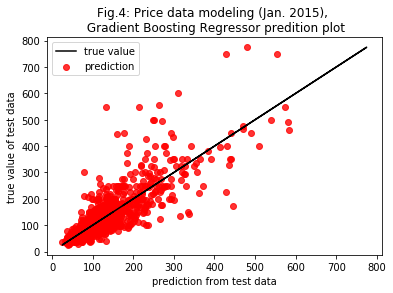

In [13]:
# Plot only the best model for later.
fig = plt.figure()
plt.scatter(y_pred_gbr_test, y_test, c='red',
            alpha=0.8, label='prediction')
plt.xlabel('prediction from test data')
plt.ylabel('true value of test data')
plt.plot(y_test, y_test, c='black', label='true value')
plt.legend()
plt.title('Fig.4: Price data modeling (Jan. 2015), \n Gradient Boosting Regressor predition plot')
plt.show()

# Save graph as image for later.
fig.savefig('./fig4.png')
plt.close(fig)

Looks like each model is predicting better in lower price range than higher price range.

Next, we extract feature importance from the best model, i.e. Gradient Boosting Regressor and plot it in sorted order.

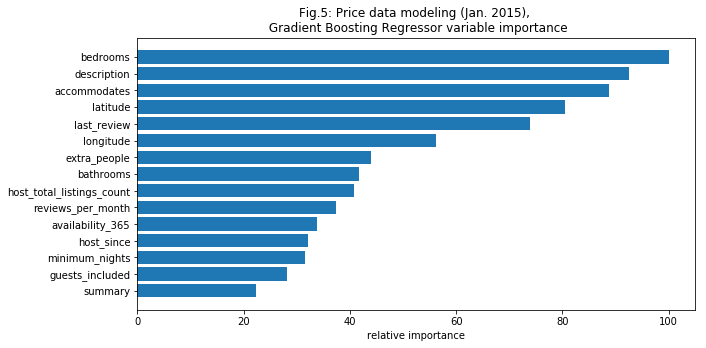

In [17]:
# Using the best score model, i.e. Gradient Boosting
# Plot feature importance in sort order
# Extract estimator from pipe
estimator = gs_gbr.best_estimator_.named_steps['est']
feature_importance = estimator.feature_importances_
feature_importance = 100.0 * \
    (feature_importance / feature_importance.max())  # max-scaling
sorted_idx = np.argsort(feature_importance)
# Extracting top 15 features
top_feature_names = X.columns.values[sorted_idx][-15:]
top_feature_importance = feature_importance[sorted_idx][-15:]

# Plot
fig = plt.figure(figsize=(10,5))
pos = np.arange(len(top_feature_names))
plt.barh(pos, top_feature_importance, align='center')
plt.yticks(pos, top_feature_names)
plt.xlabel('relative importance')
plt.title('Fig.5: Price data modeling (Jan. 2015), \n Gradient Boosting Regressor variable importance')
plt.show()

# Save graph as image for later.
fig.savefig('./fig5_.png', bbox_inches='tight')
plt.close(fig)

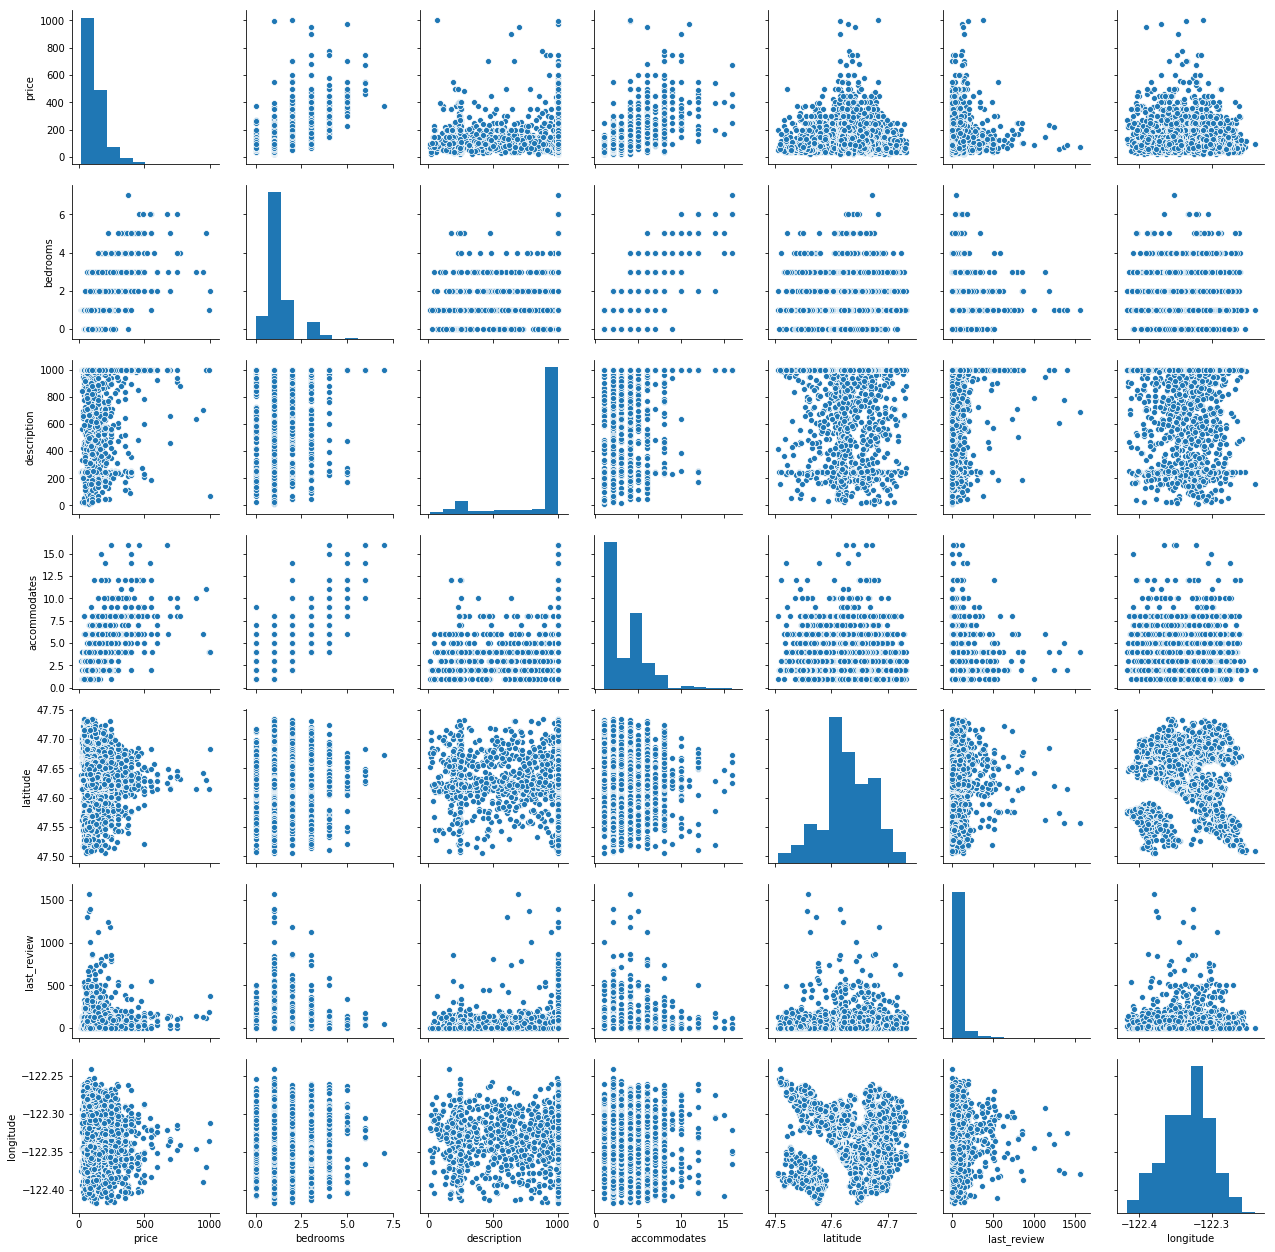

In [15]:
# In order to estimate positive / negative direction of each feature influence, we plot correlations between price and top features.
price_with_top_features_gbr = ['price', 'bedrooms', 'description',
                               'accommodates', 'latitude', 'last_review', 'longitude']
sns.pairplot(listings_df[price_with_top_features_gbr])
plt.show()

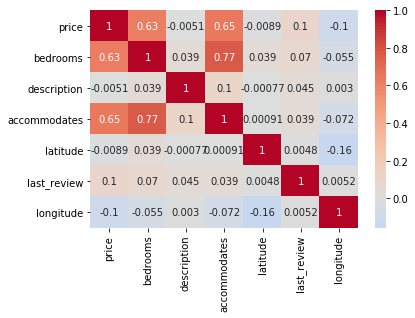

In [16]:
# Also heatmap
sns.heatmap(listings_df[price_with_top_features_gbr].corr(),
            cmap='coolwarm', center=0.0, annot=True)
plt.show()

Top important features for price predition (Gradient Boosting):
* Nuber of bedrooms
* Length of decription (better fully utilize space)
* Number of accommodates
* Coordinate (latitude, longitude) (Some optimum coordinates, i.e. hot spots)
* Time since the last review (better the last review is newer)

Now we have answers to all three business questions. (The first two were answerd in [part 2](./Seattle Airbnb Open Data - Part 2.ipynb).)

###### Q1: What are the busiest times of the year to visit Seattle? By how much do prices spike?
###### Ans.1:
* From 2016 montly price trend (fig.1) and 2009-2015 review posts trend (fig.2), busiest time can be estimated to be middle of summer, i.e. from July to August.
* Price peak month is July when price is 1.25 times more expensive compared to lowest price in January (2016).
![fig.1](./fig1.png "fig.1")
![fig.2](./fig2.png "fig.2")
###### Q2: Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?
###### Ans.2:
* Both number of visitor and number of listings are exponentially increaing from 2009 to 2015. (fig.2 and fig.3)
![fig.3](./fig3.png "fig.3")
###### Q3: How well can we predict a price of Seattle Airbnb listings? What aspects correlate well to price?
###### Ans.3:
* We can predict the price in R2 score 0.67 with Gradient Boosting model.
![fig.4](./fig4.png "fig.4")
* Regarding the Gradient Boosting model, important features for price prediction is as follows.
    * Nuber of bedrooms
    * Length of decription (better fully utilize space)
    * Number of accommodates
    * Coordinate (latitude, longitude) (Some optimum coordinates, i.e. hot spots)
    * Time since the last review (better the last review is newer)    
![fig.5](./fig5_.png "fig.5")    